### HW4Q1

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh
print(tf.__version__)

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.9.0


# Get Mnist data and split into train validation and test

In [2]:
def get_mnist(fullset = False):
    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    if not fullset:
        train_dat = train_dat[:10000]
        train_labels = train_labels[:10000]
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [3]:
def get_mnist_trans():
    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST_TEST_TRANS.npy'))
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    # print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

# Get CIFAR10 data and split into train, validation and test

In [4]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

# Get the data 

In [5]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

In [6]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):
    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

In [7]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [37]:
def create_network(f1, f2, f3, f4, deeper = False):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=f1)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=f2)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    if deeper:
        with tf.variable_scope("conv3"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu3 = conv_relu_layer(pool2, filter_size=[5, 5],num_features=f2*2)
            pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=pool_strides, padding='SAME')
        with tf.variable_scope("conv4"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu4 = conv_relu_layer(pool3, filter_size=[5, 5],num_features=f2*4)
            pool4 = tf.nn.max_pool(relu4, ksize=pool_ksize, strides=pool_strides, padding='SAME')
            
    with tf.variable_scope('dropout2'):
            drop2 = tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=f3)
            fc1r= tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=f4)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy

In [9]:
# Run the iterations of one epoch
def run_epoch(sess,OPS,data,batch_size, type="train", num=None):
        t1=time.time()
        n=data[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
    
        # Randomly shuffle the training data
        if (type=="train"):
            np.random.shuffle(ii)
        tr=data[0][ii]
        y=data[1][ii]
        loo=0.
        acc=0.
        nb=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            #if (np.mod(j,5000)==0):
                #print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            if (type=="train"):
                lo,ac,_=sess.run([OPS['cross_entropy'],OPS['accuracy'],OPS['train_step']],feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob}) 
            else:
                lo,ac = sess.run([OPS['cross_entropy'],OPS['accuracy']],feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:1.})
            loo+=lo
            acc+=ac
            nb+=1
        loo=loo/nb
        acc=acc/nb
        #print('Epoch time',time.time()-t1)
        return loo, acc

In [10]:
def getActivation(layer, filters):
    n_columns = 8
    n_rows = 4
    plt.figure(figsize=(2*n_columns, 2*n_rows))
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow((layer[:,:,:,i].eval()).reshape((5, 5)), cmap="gray")
        plt.axis('off')

# Run the training. Save the model and test at the end

In [15]:
num_epochs = 20
batch_size=500
step_size=.001
num_train=10000
minimizer="Adam"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
train,val,test=get_mnist()

(70000, 784)


In [12]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])

# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

(70000, 784)


In [45]:
def train_model(num_epochs, f1, f2, f3, f4, layer = None):
    
    train_err = np.zeros(num_epochs)
    valid_err = np.zeros(num_epochs)
    
    with tf.Session() as sess:
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy=create_network(f1, f2, f3, f4)

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        OPS={}
        OPS['cross_entropy']=cross_entropy; OPS['accuracy']=accuracy; OPS['train_step']=train_step
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
    
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            lo,ac=run_epoch(sess,OPS,train,batch_size,type="train",num=num_train)  
            train_err[i] = 1- ac
            # print('Epoch',i,'Train loss, accuracy',lo,ac)
            vlo,vac = run_epoch(sess,OPS,val,batch_size,type="test")
            valid_err[i] = 1- vac
            # print('Epoch',i,'Validation loss, accuracy',vlo,vac)
         # Test set accuracy
        telo,teac = run_epoch(sess,OPS,test,batch_size,type="test")
        print('test accuracy',telo,teac)
        
        if layer:
            Layer = tf.trainable_variables()[layer-1]
            getActivation(Layer, 32)
    
        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)
        return train_err, valid_err

### a). plot the first layer of the model

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 1, 32] 0.048521362
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028863102
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024284119
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08691603
fc2/b:0 [10] 0.0
test accuracy 0.07633079644292592 0.9803000092506409
Model saved in path: tmp/model


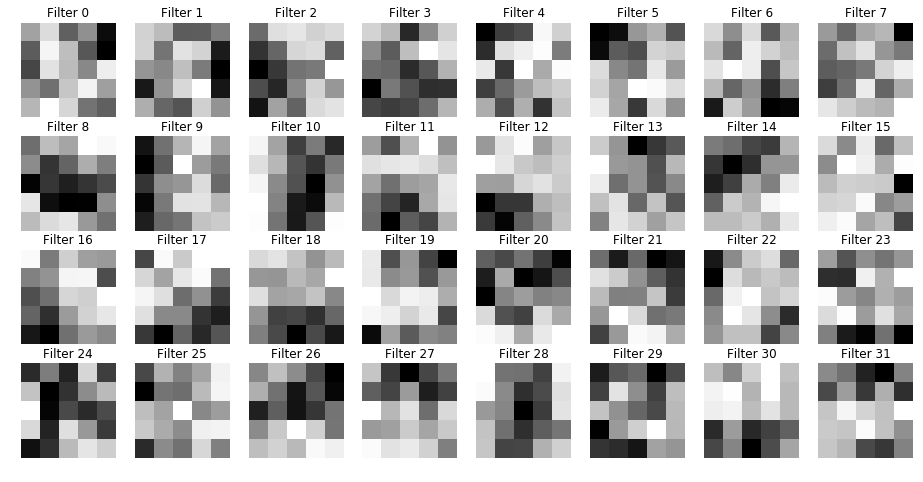

In [14]:
train_err, valid_err = train_model(20, 32, 64, 256, 10, layer = 1)

#### Compute the total number of parameters 
1. Number of parameters in convolutional layer 1: $(5 \times 5 \times 1 + 1) \times 32 = 832$
2. Number of parameters in convolutional layer 2: $(5 \times 5 \times 32 + 1) \times 64 = 51264$
3. Number of parameters in fully connected layer 1: $(3136 + 1) \times 256 = 803072$
4. Number of parameters in fully connected layer 2 - output layer: $(256 + 1) \times 10 = 2570$

Total number of parameters: $832 + 51264 + 803072 + 2570 = 857738$

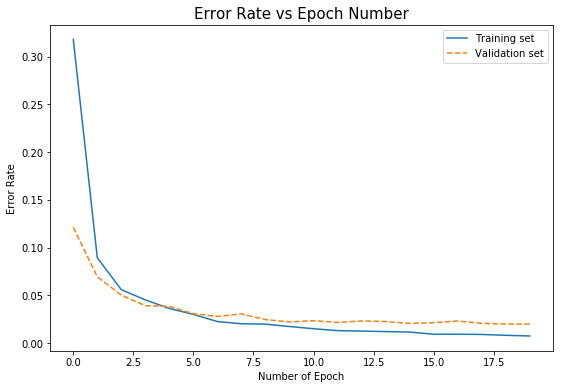

In [15]:
def plot_error(num_epochs, train_err, valid_err):
    fig = plt.figure(figsize=(9,6))
    plt.plot(list(range(num_epochs)), train_err, label="Training set")
    plt.plot(list(range(num_epochs)), valid_err, linestyle='dashed', label="Validation set")
    plt.legend()
    plt.xlabel("Number of Epoch", fontsize=10)
    plt.ylabel("Error Rate", fontsize=10)
    plt.title("Error Rate vs Epoch Number", fontsize=15)
    plt.show()
plot_error(num_epochs, train_err, valid_err)

##### b). i. Keep the same number of layers and change layer parameters reducing number of parameters by half and doubling the number parameters. Try a few different options. Report the results.

conv1/W:0 [5, 5, 1, 16] 0.06585832
conv1/b:0 [16] 0.0
conv2/W:0 [5, 5, 16, 32] 0.04092961
conv2/b:0 [32] 0.0
fc1/W:0 [1568, 128] 0.03445802
fc1/b:0 [128] 0.0
fc2/W:0 [128, 10] 0.12086388
fc2/b:0 [10] 0.0
test accuracy 0.08145869709551334 0.9748000085353852
Model saved in path: tmp/model


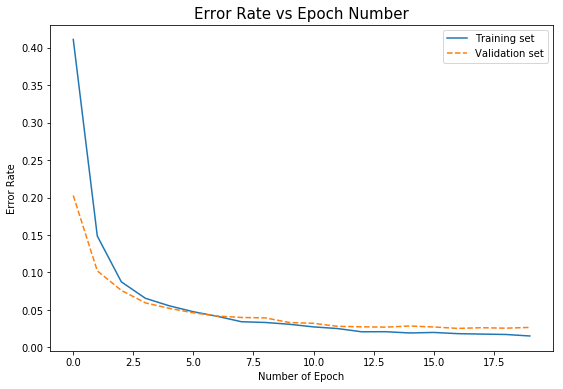

In [16]:
# reducing the number of parameters by half
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err1, valid_err1 = train_model(20, 16, 32, 128, 10)
plot_error(num_epochs, train_err1, valid_err1)

conv1/W:0 [5, 5, 1, 64] 0.03503028
conv1/b:0 [64] 0.0
conv2/W:0 [5, 5, 64, 128] 0.02043449
conv2/b:0 [128] 0.0
fc1/W:0 [6272, 512] 0.017168522
fc1/b:0 [512] 0.0
fc2/W:0 [512, 10] 0.06241075
fc2/b:0 [10] 0.0
test accuracy 0.07302702153101563 0.9830000042915344
Model saved in path: tmp/model


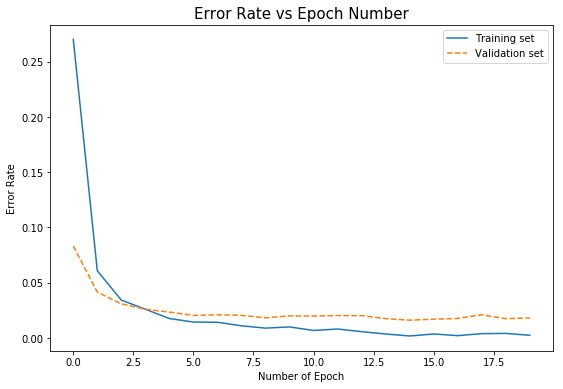

In [17]:
# doubling the number of parameters
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err2, valid_err2 = train_model(20, 64, 128, 512, 10)
plot_error(num_epochs, train_err2, valid_err2)

##### ii. Design a deeper network with the same number of parameters as the original network. Report the results.

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.048384663
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028932828
conv2/b:0 [64] 0.0
conv3/W:0 [5, 5, 64, 128] 0.020394728
conv3/b:0 [128] 0.0
conv4/W:0 [5, 5, 128, 256] 0.014433236
conv4/b:0 [256] 0.0
fc1/W:0 [3136, 256] 0.024300504
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08769862
fc2/b:0 [10] 0.0
test accuracy 0.08376029506325722 0.9779000014066697
Model saved in path: tmp/model


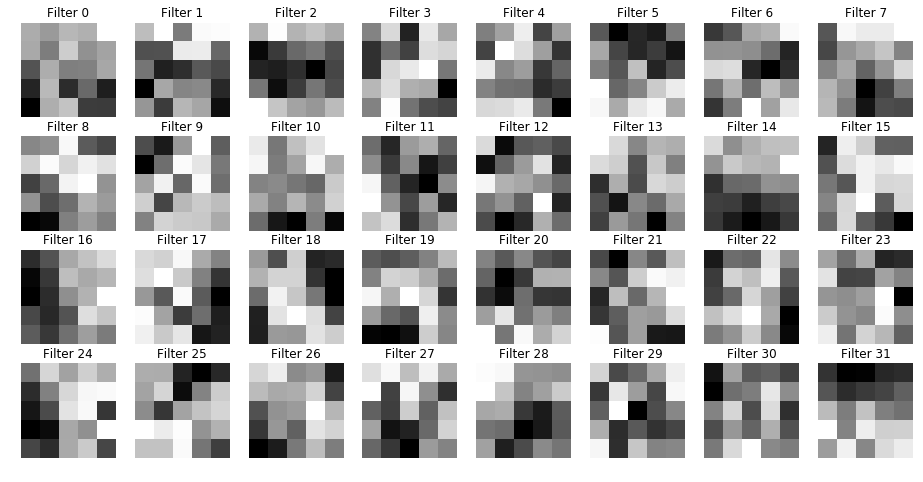

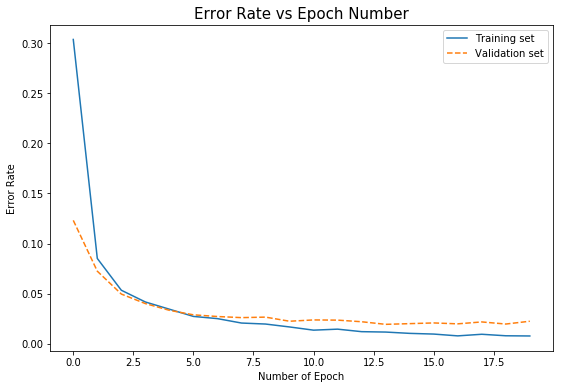

In [32]:
# set deeper as True
train,val,test=get_mnist()
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_d1, valid_err_d2 = train_model(20, 32, 64, 256, 10, True)
plot_error(num_epochs, train_err_d1, valid_err_d2)

##### Try best configuration on the full training set and report the result

In [19]:
# picking the best model configuration 
# since the the original framework has the highest test accurancy
# we pick it as the best configuration and train the full data

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.05023286
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028933056
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.02429105
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08675435
fc2/b:0 [10] 0.0
test accuracy 0.0692603929899633 0.9828000009059906
Model saved in path: tmp/model


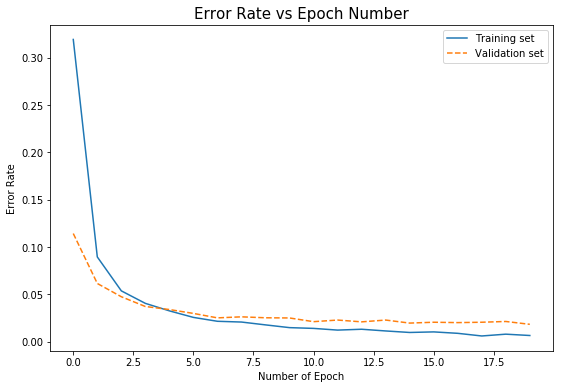

In [20]:
train,val,test=get_mnist(True)
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_b, valid_err_b = train_model(20, 32, 64, 256, 10)
plot_error(num_epochs, train_err_b, valid_err_b)

##### Handling variability

In [13]:
train_t,val_t,test_t=get_data('mnist_transform')

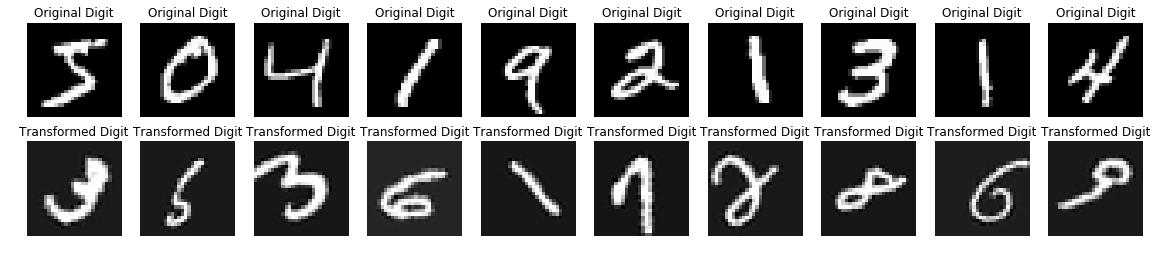

In [22]:
nrows = 2
ncols = 10
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    if i < ncols:
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(train[0][i].reshape((28,28)), cmap='gray')
        plt.title("Original Digit")
        plt.axis('off')
    else:
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(train_t[0][i].reshape((28,28)), cmap='gray')
        plt.title("Transformed Digit")
        plt.axis('off')        
plt.axis('off')
plt.show()

conv1/W:0 [5, 5, 1, 32] 0.04833647
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028863652
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024283662
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.086739115
fc2/b:0 [10] 0.0
test accuracy 2.2976348042488097 0.12159999944269657
Model saved in path: tmp/model


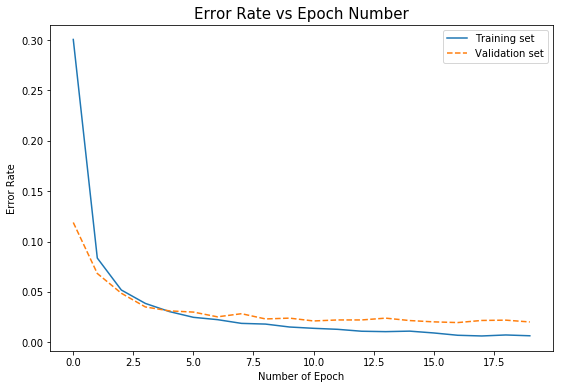

In [23]:
# test classfication model using the rotated data set
test = test_t
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_t, valid_err_t = train_model(20, 32, 64, 256, 10)
plot_error(num_epochs, train_err_t, valid_err_t)

It can be seen that the test accurancy for the rotated image is only 0.1216.

conv1/W:0 [5, 5, 1, 32] 0.04927641
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.02874747
conv2/b:0 [64] 0.0
conv3/W:0 [5, 5, 64, 128] 0.020422567
conv3/b:0 [128] 0.0
conv4/W:0 [5, 5, 128, 256] 0.014434024
conv4/b:0 [256] 0.0
fc1/W:0 [3136, 256] 0.024284152
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08577568
fc2/b:0 [10] 0.0
test accuracy 2.2993882298469543 0.12940000146627426
Model saved in path: tmp/model


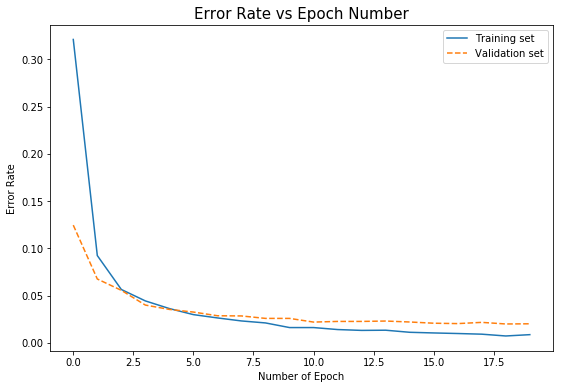

In [44]:
## propose a new framework
# increase the number of layers
# set deeper as true 
test = test_t
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_new, valid_err_new = train_model(20, 32, 64, 256, 10)
plot_error(num_epochs, train_err_new, valid_err_new)